In [1]:
import os
import os.path as osp
import numpy as np
import pandas as pd
import scipy
import scipy.stats
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
import torch
from sklearn import metrics
import pickle
from tqdm import tqdm
import itertools
import gffutils
import argparse
import sqlite3
import json
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
def load_pred(pred_dir, ct, chrom, pred_len=200, avg_stripe=False):
    file = osp.join(pred_dir, ct, 'prediction_{}_chr{}.npz'.format(ct, chrom))
    temp = np.load(file)['arr_0']
    chrom_len = temp.shape[0]
    prep = np.insert(temp, pred_len, 0, axis=1)
    mat = np.array([
        np.insert(np.zeros(chrom_len+pred_len+1), i, prep[i]) for i in range(chrom_len)
    ])
    summed = np.vstack((
        np.zeros((pred_len, mat.shape[1])), mat
    )).T[:chrom_len+pred_len, :chrom_len+pred_len]
    if avg_stripe:
        summed = (summed + np.vstack((
            np.zeros((pred_len, mat.shape[1])), mat
        ))[:chrom_len+pred_len, :chrom_len+pred_len])/2
    
    return summed[pred_len:-pred_len, pred_len:-pred_len]

In [3]:
def topdom(pred_mat, window_size=50, cutoff=0):
    if pred_mat.shape[0]-pred_mat.shape[1]:
        raise ValueError(
            'Dimension mismatch ({}, {})'.format(pred_mat.shape[0], pred_mat.shape[1])
        )
    pad_mat = np.pad(pred_mat, window_size, mode='constant', constant_values=np.nan)
    dim = pad_mat.shape[0]
    signal = np.array([
        np.nanmean(pad_mat[i-window_size:i, i:i+window_size]) for i in range(dim)
    ][window_size+1: -window_size])
    if cutoff is not None:
        signal[signal<cutoff] = cutoff

    return signal


def interpolate(signal, bin_size=10000, pattern='smooth'):
    if pattern is None: return signal
    if pattern not in ['smooth', 'zigzag']:
        raise ValueError(
            'Bad parameter, expecting \'smooth\' or \'zigzag\' but got \'{}\''.format(pattern)
        )
    if pattern=='smooth':
        l = len(signal) * bin_size
        sparse, compact = np.linspace(0, l, len(signal)), np.linspace(0, l, l)
        interp_signal = np.interp(compact, sparse, signal)
    else:
        interp_signal = np.tile(signal, (bin_size, 1)).flatten('F')
    
    return interp_signal


def sim_pearson(signal1, signal2, window_size=10):
    l = len(signal1)
    score = np.array([
        scipy.stats.pearsonr(
            signal1[i:i+window_size], signal2[i:i+window_size]
        )[0] for i in range(l-window_size)
    ])
    score[score != score] = 1

    return score


def sim_difference(signal1, signal2):
    score = signal1 - signal2
    score[score != score] = 0

    return score


def similarity(signal1, signal2, kernel='diff', window_size=10):
    if len(signal1)-len(signal2):
        raise ValueError(
            'Different signal1.length ({}) and signal2.length ({})'.format(len(signal1), len(signal2))
        )
    if kernel == 'diff':
        score = sim_difference(signal1, signal2)
    elif kernel == 'pearson':
        score = sim_pearson(signal1, signal2, window_size=window_size)
    
    return score

In [4]:
def rotate_coord(n):
    tmp = np.array(list(itertools.product(range(n,-1,-1),range(0,n+1,1))))
    tmp[:, [0, 1]] = tmp[:, [1, 0]]
    A = tmp.dot(np.array([[1, 0.5], [-1, 0.5]]))
    
    return A

def plot_pred(predmat1, predmat2, ct1, ct2, chrom, start, gene, locstart, locend):
    plt.rcParams['figure.figsize'] = 8, 9.5
    plt.rcParams['figure.autolayout'] = False

    fig, axs = plt.subplots(3, 1, sharex=True)
    fig.suptitle('chr{} - {}'.format(chrom, gene), fontsize=15)
    fig.tight_layout(rect=[0.01, 0.03, 1, 9/9.5], h_pad=2)
    
    vmaxs, vmins = [4, 4, 2], [-1, -1, -2]
    pred1 = np.triu(predmat1[start:start+700, start:start+700])
    pred2 = np.triu(predmat2[start:start+700, start:start+700])
    preds = [pred1, pred2, pred1-pred2]
    cts = [ct1, ct2, 'Difference']
    
    for i in range(3):
        ax, pred, ct = axs[i], preds[i], cts[i]
        n = pred.shape[0]
        A = rotate_coord(n)
        img = ax.pcolormesh(A[:, 1].reshape(n+1, n+1), A[:, 0].reshape(n+1, n+1),
                            np.flipud(pred), cmap='RdBu_r', vmax=vmaxs[i], vmin=vmins[i])
        ax.title.set_text(ct)
        ax.set_xlim(300, 500)
        ax.set_ylim(0, 200)
        ax.set_xticklabels(np.linspace(start+300, start+500, num=len(ax.get_xticks()), dtype=int))
        
        x = np.arange(300, 500)
        y1, y2 = np.absolute(2*x-2*locstart), np.absolute(2*x-2*locend)
        ax.plot(x, y1, color='magenta', alpha=0.3)
        ax.plot(x, y2, color='magenta', alpha=0.3)
        plt.colorbar(img, ax=ax)
        
    plt.xlabel('chr{} (10kb)'.format(chrom))
    plt.show()

In [5]:
%%time

pred_dir = '/data/leslie/suny4/predictions/chromafold/'
ct1, ct2 = 'mycGCB_am_gfp_myc_gcb_thelp_sample', 'mycGCB_am_gfp_myc_gcb_nothelp_sample'
chrom = 1
pred1, pred2 = load_pred(pred_dir, ct1, chrom, avg_stripe=True), load_pred(pred_dir, ct2, chrom, avg_stripe=True)

CPU times: user 11 s, sys: 7.97 s, total: 19 s
Wall time: 19.2 s


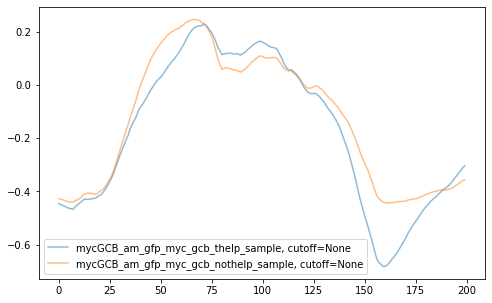

CPU times: user 2.92 s, sys: 1.25 s, total: 4.17 s
Wall time: 4.22 s


In [6]:
%%time

td1_nocutoff, td2_nocutoff = topdom(pred1, cutoff=None), topdom(pred2, cutoff=None)
plt.figure(figsize=(8,5))
plt.plot(td1_nocutoff[7400:7600], alpha=0.5, label='{}, cutoff=None'.format(ct1))
plt.plot(td2_nocutoff[7400:7600], alpha=0.5, label='{}, cutoff=None'.format(ct2))
plt.legend()
plt.show()

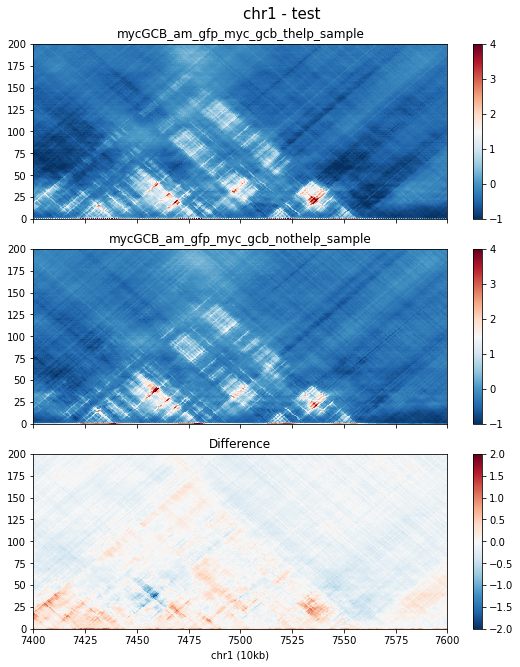

In [7]:
plot_pred(pred1, pred2, ct1, ct2, chrom, 7100, 'test', 7500, 7500)

In [ ]:
%%time

def quantile_norm(pred1, pred2):
    l = pred1.shape[0]
    pred1_diag = np.array([np.pad(np.diagonal(pred1, offset=i), (0, i), 'constant') for i in range(200)]).T
    pred2_diag = np.array([np.pad(np.diagonal(pred2, offset=i), (0, i), 'constant') for i in range(200)]).T
    pred = np.column_stack((pred1_diag.ravel(), pred2_diag.ravel()))
    df, df_sorted = pd.DataFrame(pred), pd.DataFrame(np.sort(pred, axis=0))
    df_mean = df_sorted.mean(axis=1)
    df_mean.index += 1
    df_qn = df.rank(method='min').stack().astype(int).map(df_mean).unstack()
    pred1_stripe, pred2_stripe = df_qn[0].values.reshape(-1,200), df_qn[1].values.reshape(-1,200)
    
    pred1_qn, pred2_qn = np.zeros_like(pred1), np.zeros_like(pred2)
    for i in tqdm(range(200)):
        idx = np.arange(pred1.shape[0]-i, dtype=int)
        pred1_qn[idx, idx+i] = pred1_qn[idx+i, idx] = pred1_stripe[:pred1.shape[0]-i, i]
        pred2_qn[idx, idx+i] = pred2_qn[idx+i, idx] = pred2_stripe[:pred1.shape[0]-i, i]
    
    return pred1_qn, pred2_qn

pred1_qn, pred2_qn = quantile_norm(pred1, pred2)

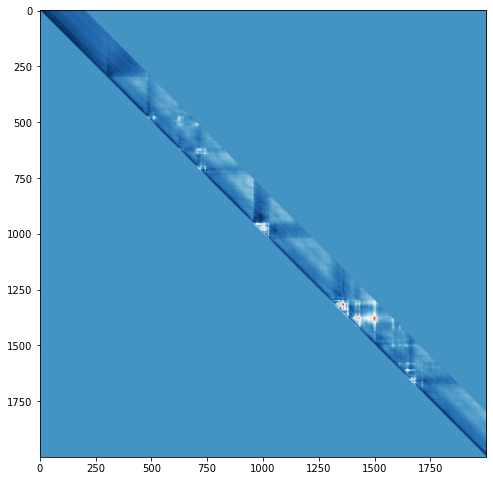

In [162]:
pred1_new = np.zeros_like(pred1)
for i in range(200):
    rng = np.arange(pred1.shape[0]-i, dtype=int)
    pred1_new[rng, rng+i] = pred1_stripe[:pred1.shape[0]-i,i]
plt.imshow(pred1_new[:2000,:2000], cmap='RdBu_r', vmax=4, vmin=-1)
plt.show()